In [1]:
import numpy as np
#! pip install pygad
import pygad.gann
from sklearn import preprocessing

In [2]:
#solutions_num - liczba rozwiązań np. 5
#input_num - liczba neuronów w warstwie wejściowej np. 3
#hidden_num - ilość neuronów w warstwach ukrytych np. [2] lub [5, 2]
#output_num - liczba neuronów w warstwie wyjściowej np. 1
#hidden_act - rodzaj funkcji aktywacji dla warstw ukrytych np. ["relu"] lub ["sigmoid", "relu"] ("sigmoid", "relu", "softmax", "None")
class NeuralNetwork:
    # Konstruktor sieci neuronowej
    def __init__(self, input_data, output_data, solutions_num, input_layers_num, hidden_layers_num, output_layers_num, hidden_layers_act, output_layers_act):
        if len(hidden_layers_num) != len(hidden_layers_act):
            raise Exception('Number of hidden layers must be equal number of hidden activation functions')
        
        if solutions_num < 2:
            raise Exception('At least one value is required')
        
        # Ustawienie danych wejściowych
        self.input_data = input_data
        # Ustawienie danych wyjściowych ????????????
        self.output_data = output_data
        # Tworzenie sieci neuronowych
        self.instance = pygad.gann.GANN(num_solutions=solutions_num,
                                num_neurons_input=input_layers_num,
                                num_neurons_hidden_layers=hidden_layers_num,
                                num_neurons_output=output_layers_num,
                                hidden_activations=hidden_layers_act,
                                output_activation=output_layers_act)
        # Tablica populacji
        self.population_array = pygad.gann.population_as_vectors(population_networks=self.instance.population_networks)
    # Wypisanie wag każdej sieci
    def PrintWeights(self):
        for i, val in enumerate(self.population_array):
            print(f'Network number: {i}')
            for j, value in enumerate(val):
                print(f'Weight {j}: {value}')
            print("\n")

# neural_network - instancja klasy NeuralNetwork
# generation_num - liczba generacji(iteracji)
# parent_num - liczba rodziców z których powstaną nowe osobniki
# mutation_perc - procent szansy na mutację
class GeneticAlgorithm:
    def __init__(self, neural_network, generation_num, parent_num, mutation_perc):
        if parent_num > neural_network.instance.num_solutions:
            raise Exception('parents number cannot be higher than population number')
        
        self.instance = pygad.GA(num_generations=generation_num, 
                       num_parents_mating=parent_num, 
                       initial_population=neural_network.population_array.copy(),
                       fitness_func=fitness_function,
                       mutation_percent_genes=mutation_perc,
                       on_generation=on_generation)
    
    def run(self):
        self.instance.run()
    
    def plot_result(self):
        self.instance.plot_result()
        
    def best_result(self):
        solution, solution_fitness, solution_idx = self.instance.best_solution()
        print(f'Solution: {solution}')
        print(f'Solution fitness: {solution_fitness}')
        print(f'Solution index: {solution_idx}')
        
# Obliczanie funkcji dopasowania
def fitness_function(solution, solution_index):
    global nn
    predictions = pygad.nn.predict(last_layer=nn.instance.population_networks[solution_index],
                                   data_inputs=nn.input_data,
                                   problem_type="classification")
    correct_predictions = np.where(predictions == nn.output_data)[0].size
    solution_fitness = (correct_predictions/nn.output_data.size)*100
    return solution_fitness

# Funkcja aktualizująca wagi
def on_generation(ga_instance):
    global nn, ga
    
    population_matrices = pygad.gann.population_as_matrices(population_networks=nn.instance.population_networks,
                                                            population_vectors=ga.instance.population)
    nn.instance.update_population_trained_weights(population_trained_weights=population_matrices)

    #print("Generation = {generation}".format(generation=ga.instance.generations_completed))
    #print("Accuracy   = {fitness}".format(fitness=ga.instance.best_solution()[1]))

In [3]:
data = np.genfromtxt('diabetes.csv', delimiter=',')
cols = data[:,:8] # pierwsze 8 kolumn
last_cols = data[:,8] # ostatnia kolumna (nr 9)
min_max_scaler = preprocessing.MinMaxScaler()
data_inputs = min_max_scaler.fit_transform(cols.T).T
data_outputs = last_cols

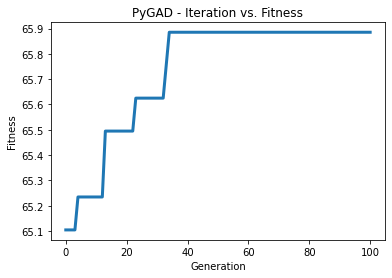

Solution: [ 2.81450442e-02  7.54438572e-02 -1.40696752e-01  4.53998196e-02
 -1.78165474e+00 -3.06596026e-02 -6.72733325e-02 -5.91214274e-02
  6.68469951e-05  4.52290878e-01  1.33738664e+00 -6.69399434e-01
 -1.44251245e-02 -5.36792224e-01 -6.82031296e-01 -9.23804122e-02
 -7.48922397e-01  5.13903743e-01  9.56762987e-02 -2.12674405e+00
  9.48905686e-02  1.34338898e-02 -2.05300611e+00  1.30023121e-01
  6.22121871e-02 -9.51197789e-02 -6.80327283e-02  1.53610306e-01
 -9.02534267e-03 -6.45840016e-01  1.45902798e-02 -9.65684783e-02
 -1.37278481e-01 -7.22961908e-03]
Solution fitness: 65.88541666666666
Solution index: 0


In [6]:
nn = NeuralNetwork(input_data=data_inputs, 
                  output_data=data_outputs, 
                  solutions_num=10, 
                  input_layers_num=8, 
                  hidden_layers_num=[3, 2], 
                  output_layers_num=2,
                  hidden_layers_act=["relu", 'relu'], 
                  output_layers_act="softmax")

ga = GeneticAlgorithm(neural_network=nn,
                      generation_num=100,
                      parent_num=2,
                      mutation_perc=5)
ga.run()
ga.plot_result()
ga.best_result()